In [6]:
!git clone https://github.com/sony/gibbsddrm.git


fatal: destination path 'gibbsddrm' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install lpips
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [8]:
%cd /content/gibbsddrm


/content/gibbsddrm


In [9]:
## Import package

import argparse
import traceback
import shutil
import logging
import yaml
import sys
import os
import torch
import numpy as np
from runners.diffusion import Diffusion
import torch.utils.data as data
import torchvision.utils as tvu
from torch.nn.parallel import DataParallel
import tqdm
from datasets import data_transform, get_dataset, inverse_data_transform
from functions.ckpt_util import download, get_ckpt_path
from functions.denoising import sample_gibbsddrm
from guided_diffusion.script_util import (args_to_dict, classifier_defaults,
                                          create_classifier, create_model)
from guided_diffusion.unet import UNetModel
from models.diffusion import Model
from pytz import timezone
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torch.utils.tensorboard.writer import SummaryWriter
import glob
import random
from datetime import datetime
import lpips


In [10]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

In [11]:
## Parse config

def parse_args_and_config(config_path, seed=1234, exp="exp", doc=None, comment="", verbose="info", sample=False,
                          image_folder="images", ni=False, deg=None, subset_start=-1, subset_end=-1):

    class Args:
        pass

    args = Args()

    args.config = config_path
    args.seed = seed
    args.exp = exp
    args.doc = doc
    args.comment = comment
    args.verbose = verbose
    args.sample = sample
    args.image_folder = image_folder
    args.ni = ni
    args.deg = deg
    args.subset_start = subset_start
    args.subset_end = subset_end

    args.log_path = os.path.join(args.exp, "logs", args.doc)

    # parse config file
    with open(os.path.join("configs", args.config), "r") as f:
        config = yaml.safe_load(f)
    new_config = dict2namespace(config)

    level = getattr(logging, args.verbose.upper(), None)
    if not isinstance(level, int):
        raise ValueError("level {} not supported".format(args.verbose))

    handler1 = logging.StreamHandler()
    formatter = logging.Formatter(
        "%(levelname)s - %(filename)s - %(asctime)s - %(message)s"
    )
    handler1.setFormatter(formatter)
    logger = logging.getLogger()
    logger.addHandler(handler1)
    logger.setLevel(level)

    os.makedirs(os.path.join(args.exp, "image_samples"), exist_ok=True)
    args.image_folder = os.path.join(
        args.exp, "image_samples", args.image_folder
    )
    if not os.path.exists(args.image_folder):
        os.makedirs(args.image_folder)
    else:
        overwrite = False
        if args.ni:
            overwrite = True
        else:
            response = input(
                f"Image folder {args.image_folder} already exists. Overwrite? (Y/N)"
            )
            if response.upper() == "Y":
                overwrite = True

        if overwrite:
            shutil.rmtree(args.image_folder)
            os.makedirs(args.image_folder)
        else:
            print("Output image folder exists. Program halted.")
            sys.exit(0)

    # add device
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    logging.info("Using device: {}".format(device))
    new_config.device = device

    # set random seed
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

    torch.backends.cudnn.benchmark = True

    return args, new_config

# Example usage in Jupyter Notebook
args, config = parse_args_and_config(
    config_path="ffhq_256_deblur.yml",
    doc="your_documentation_string",
    deg="deblur_arbitral"
)


INFO:root:Using device: cuda
INFO - <ipython-input-11-caa3a2c1c63c> - 2024-04-08 07:53:31,160 - Using device: cuda


In [12]:
## Define beta schedule

def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    return betas



betas = get_beta_schedule(
            beta_schedule=config.diffusion.beta_schedule,
            beta_start=config.diffusion.beta_start,
            beta_end=config.diffusion.beta_end,
            num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps,
        )

In [13]:
## set up GPU device

device = (
                torch.device("cuda")
                    if torch.cuda.is_available()
                    else torch.device("cpu")
                )
device

device(type='cuda')

In [14]:
## set up parameters for algorithms

model_var_type = config.model.var_type
betas = torch.from_numpy(betas).float().to(device)
num_timesteps = betas.shape[0]


alphas = 1.0 - betas
alphas_cumprod = alphas.cumprod(dim=0)
alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), alphas_cumprod[:-1]], dim=0
        )

posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )

In [15]:
config_dict = vars(config.model)

config_dict

{'type': 'openai',
 'image_size': 256,
 'num_channels': 128,
 'num_res_blocks': 1,
 'channel_mult': '',
 'learn_sigma': True,
 'class_cond': False,
 'use_checkpoint': False,
 'num_heads': 4,
 'num_head_channels': 64,
 'num_heads_upsample': -1,
 'use_scale_shift_norm': True,
 'dropout': 0.0,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'var_type': 'learned_range'}

# Experiments

## Reproduce the result of the paper

In [17]:
## Create diffusion model

model = create_model(**config_dict)

model.load_state_dict(torch.load('/content/drive/MyDrive/tien/models/ffhq_10m.pt', map_location=device))
model.to(device)
model.eval()
model = DataParallel(model)

In [18]:
## Get the dataset

dataset, test_dataset = get_dataset(args, config)

g = torch.Generator()
g.manual_seed(args.seed)
val_loader = data.DataLoader(
            test_dataset,
            batch_size=config.sampling.batch_size,
            shuffle=True,
            num_workers=config.data.num_workers,
            generator=g,
        )

pbar = tqdm.tqdm(val_loader)

for x_orig, classes in pbar:
    print(x_orig.shape)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

torch.Size([2, 3, 256, 256])


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


In [19]:
args.subset_start = 0
args.subset_end = len(test_dataset)
idx_init = args.subset_start
idx_so_far = args.subset_start

In [22]:
## Create convolution matrix to deblur image

from functions.svd_replacement import DeblurringArbitral2D

conv_type = config.deblur.conv_type


In [24]:
## Defind sigma_0 for degradation model

sigma_0 = 2 * config.deblur.sigma_0
sigma_0

0.04

In [25]:
batch_size = x_orig.shape[0]
kernel_batch = DeblurringArbitral2D.get_blur_kernel_batch(batch_size, config.deblur.kernel_type, device)
kernel_uncert_batch = \
                DeblurringArbitral2D.corrupt_kernel_batch(kernel_batch, \
                                                                 config.deblur.kernel_corruption, \
                                                                 config.deblur.kernel_corruption_coef)


H_funcs = DeblurringArbitral2D(kernel_batch, config.data.channels, config.data.image_size, device, conv_type)
H_funcs_uncert = DeblurringArbitral2D(kernel_uncert_batch, config.data.channels, config.data.image_size, device, conv_type)

In [26]:
## deblur the image with pre-defind blur kenel and sigma_0

x_orig = x_orig.to(device)
x_orig = data_transform(config, x_orig)
y_0 = H_funcs.H(x_orig)
y_0 = y_0 + sigma_0 * torch.randn_like(y_0)

WARNING - image.py - 2024-04-08 07:55:24,725 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


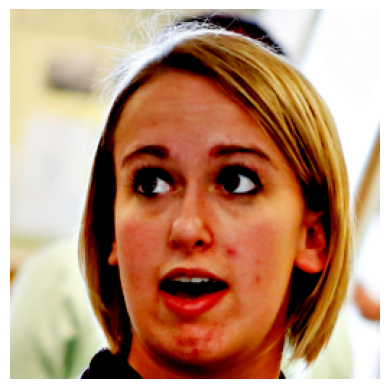

In [27]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x_orig[1]  # Example random tensor, replace with your own data

# Ensure the tensor is on CPU before converting to a numpy array
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

WARNING - image.py - 2024-04-08 07:55:26,097 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


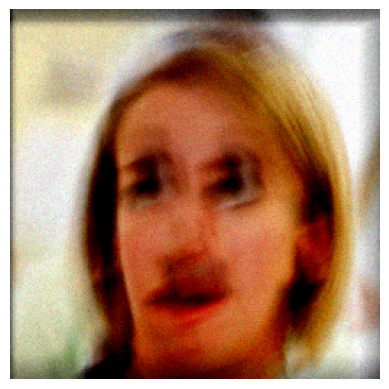

In [28]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = y_0[1]  # Example random tensor, replace with your own data

# Ensure the tensor is on CPU before converting to a numpy array
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

In [29]:
## GIBBSDDRM algorithm

def sample_image(x, model, H_funcs, y_0, sigma_0, last=True, cls_fn=None, classes=None):
        skip = num_timesteps // config.deblur.timesteps
        seq = range(0, num_timesteps, skip)

        x_init = x

        for i_ddrm in range(config.deblur.iter_DDRM):

            x = sample_gibbsddrm(x_init, seq, model, betas, H_funcs, y_0, sigma_0, \
                    etaB=config.deblur.etaB, etaA=config.deblur.etaA, etaC=config.deblur.etaC, etaD = config.deblur.etaD, cls_fn=cls_fn, classes=classes,
                    config=config)

            if config.logger.enable_log:
                # Log DDRM output
                x_on_cpu = config.logger.inverse_data_transform(config, x[0][-1])
                x_on_cpu = x_on_cpu.to("cpu").detach()
                config.logger.writer.add_images("DDRM output", x_on_cpu, i_ddrm)
                # Log kernel
                kernel_on_cpu = H_funcs.kernel[:, None, :, :].repeat(1, 3, 1, 1).to("cpu").detach()
                config.logger.writer.add_images("Refined kernel", torch.abs(kernel_on_cpu)/torch.max(torch.abs(kernel_on_cpu)), i_ddrm)

        if last:
            x = [x[0][-1]]
        return x

In [30]:
## start from a random noise

x = torch.randn(
                y_0.shape[0],
                config.data.channels,
                config.data.image_size,
                config.data.image_size,
                device=device,
            )

In [31]:
dt_now = datetime.now(timezone('Asia/Tokyo'))
dt_str = dt_now.strftime('%Y_%m%d_%H%M%S')
image_folder = args.image_folder + dt_str
os.makedirs(image_folder, exist_ok=False)

config_path = os.path.join("configs", args.config)
shutil.copyfile(config_path, os.path.join(image_folder, args.config))


config.logger.writer = SummaryWriter(image_folder)
config.logger.image_folder = image_folder
config.logger.inverse_data_transform = inverse_data_transform

In [129]:
x = sample_image(x, model, H_funcs_uncert, y_0, sigma_0, last=True, cls_fn=None, classes=classes)

100it [06:15,  3.76s/it]


WARNING - image.py - 2024-04-07 20:27:30,404 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - image.py - 2024-04-07 20:27:30,404 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

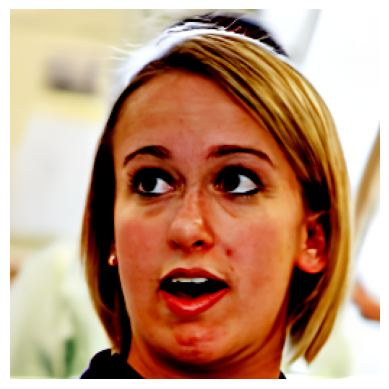

In [130]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x[0][1]  # Example random tensor, replace with your own data

# Convert the tensor to a numpy array and transpose dimensions
# For visualization, the tensor dimensions should be (height, width, channels)
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hid

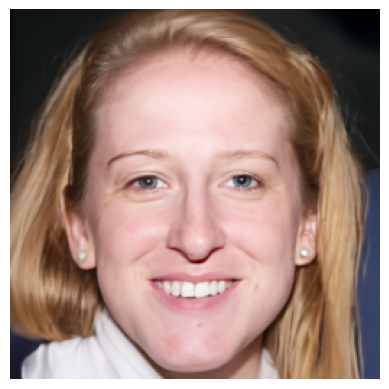

In [132]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_org_0', bbox_inches='tight', pad_inches=0)


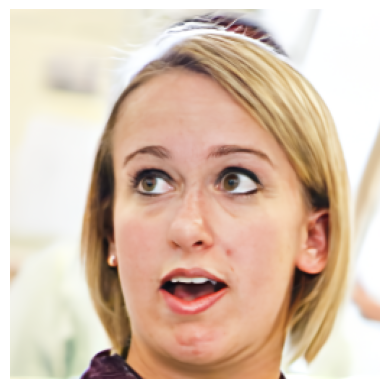

In [133]:
plt.imshow(x_result[0][1].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_org_1', bbox_inches='tight', pad_inches=0)

## Change the noise of degradation model to new value not used in the paper

In [32]:
sigma_0 = 2 * 0.005

y_0 = H_funcs.H(x_orig)
y_0 = y_0 + sigma_0 * torch.randn_like(y_0)

WARNING - image.py - 2024-04-08 07:56:06,635 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


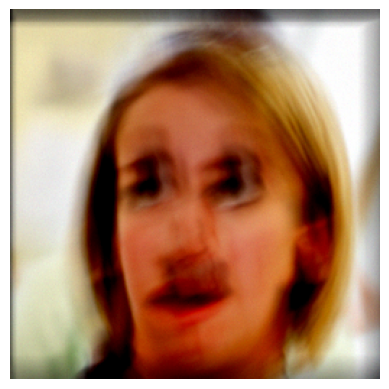

In [33]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = y_0[1]  # Example random tensor, replace with your own data

# Ensure the tensor is on CPU before converting to a numpy array
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

In [34]:

x = torch.randn(
                y_0.shape[0],
                config.data.channels,
                config.data.image_size,
                config.data.image_size,
                device=device,
            )

In [35]:
x = sample_image(x, model, H_funcs_uncert, y_0, sigma_0, last=True, cls_fn=None, classes=classes)

100it [06:28,  3.88s/it]


WARNING - image.py - 2024-04-08 08:03:16,737 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

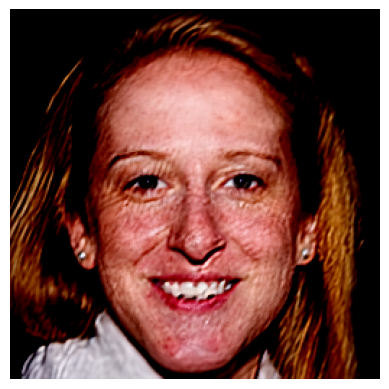

In [38]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x[0][0]  # Example random tensor, replace with your own data

# Convert the tensor to a numpy array and transpose dimensions
# For visualization, the tensor dimensions should be (height, width, channels)
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hid

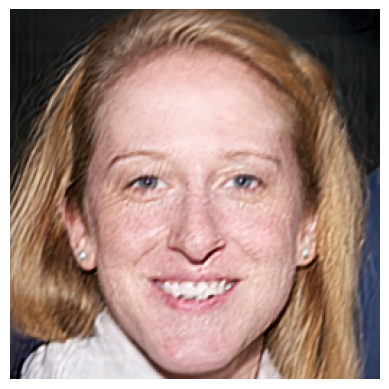

In [39]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_change_noise_0', bbox_inches='tight', pad_inches=0)

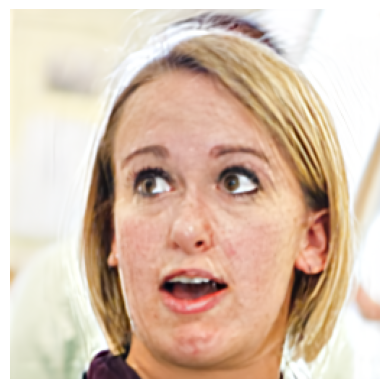

In [40]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][1].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_change_noise_1', bbox_inches='tight', pad_inches=0)

## Change the diffusion model


### afhqdog model

In [166]:
## Create diffusion model

model = create_model(**config_dict)

model.load_state_dict(torch.load('/content/drive/MyDrive/tien/models/afhqdog_p2.pt', map_location=device))
model.to(device)
model.eval()
model = DataParallel(model)

In [167]:
sigma_0 = 2 * config.deblur.sigma_0

y_0 = H_funcs.H(x_orig)
y_0 = y_0 + sigma_0 * torch.randn_like(y_0)

In [168]:

x = torch.randn(
                y_0.shape[0],
                config.data.channels,
                config.data.image_size,
                config.data.image_size,
                device=device,
            )

In [171]:
x = sample_image(x, model, H_funcs_uncert, y_0, sigma_0, last=True, cls_fn=None, classes=classes)

100it [06:16,  3.77s/it]


WARNING - image.py - 2024-04-07 21:19:58,755 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - image.py - 2024-04-07 21:19:58,755 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

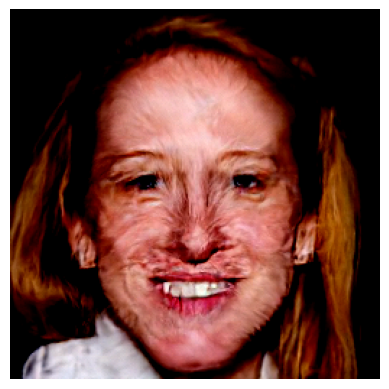

In [172]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x[0][0]  # Example random tensor, replace with your own data

# Convert the tensor to a numpy array and transpose dimensions
# For visualization, the tensor dimensions should be (height, width, channels)
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hid

In [ ]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_change_model_0', bbox_inches='tight', pad_inches=0)

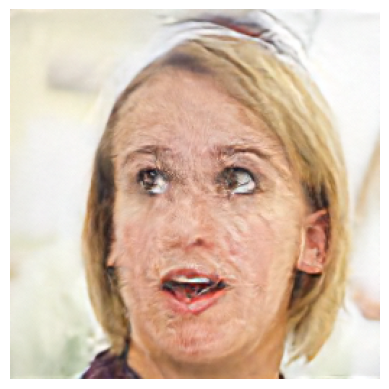

In [174]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][1].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_change_model_1', bbox_inches='tight', pad_inches=0)

### celebahq model

In [44]:
## Create diffusion model

model = create_model(**config_dict)

model.load_state_dict(torch.load('/content/drive/MyDrive/tien/models/celebahq_p2.pt', map_location=device))
model.to(device)
model.eval()
model = DataParallel(model)

In [45]:
sigma_0 = 2 * config.deblur.sigma_0

y_0 = H_funcs.H(x_orig)
y_0 = y_0 + sigma_0 * torch.randn_like(y_0)

In [46]:
x = torch.randn(
                y_0.shape[0],
                config.data.channels,
                config.data.image_size,
                config.data.image_size,
                device=device,
            )

In [47]:
x = sample_image(x, model, H_funcs_uncert, y_0, sigma_0, last=True, cls_fn=None, classes=classes)

100it [06:24,  3.85s/it]


WARNING - image.py - 2024-04-08 08:14:39,309 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

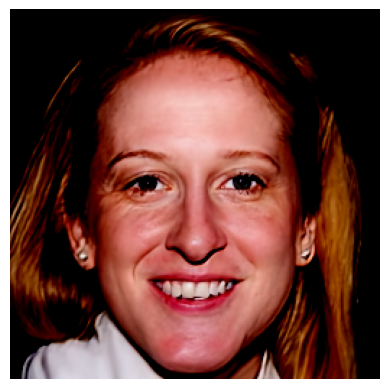

In [48]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x[0][0]  # Example random tensor, replace with your own data

# Convert the tensor to a numpy array and transpose dimensions
# For visualization, the tensor dimensions should be (height, width, channels)
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hid

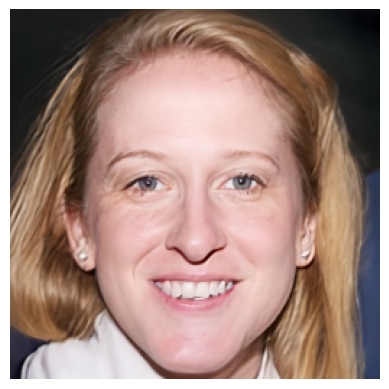

In [51]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_model_celebahq_0', bbox_inches='tight', pad_inches=0)

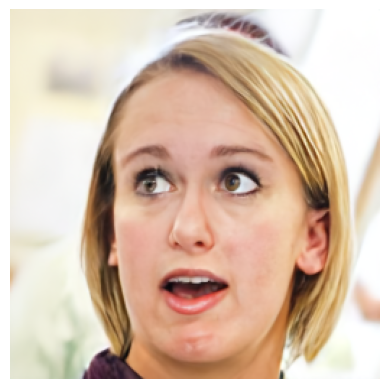

In [50]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][1].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_model_celebahq_1', bbox_inches='tight', pad_inches=0)

### metface model

In [52]:
## Create diffusion model

model = create_model(**config_dict)

model.load_state_dict(torch.load('/content/drive/MyDrive/tien/models/metface_p2.pt', map_location=device))
model.to(device)
model.eval()
model = DataParallel(model)

In [53]:
sigma_0 = 2 * config.deblur.sigma_0

y_0 = H_funcs.H(x_orig)
y_0 = y_0 + sigma_0 * torch.randn_like(y_0)

In [54]:
x = torch.randn(
                y_0.shape[0],
                config.data.channels,
                config.data.image_size,
                config.data.image_size,
                device=device,
            )

In [55]:
x = sample_image(x, model, H_funcs_uncert, y_0, sigma_0, last=True, cls_fn=None, classes=classes)

100it [06:22,  3.82s/it]


WARNING - image.py - 2024-04-08 08:31:11,580 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

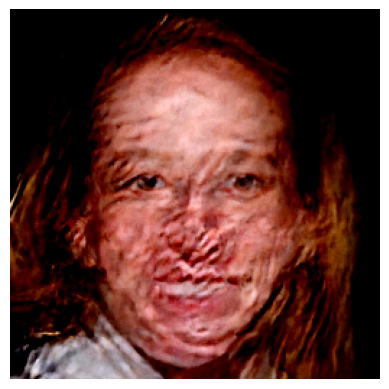

In [56]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x[0][0]  # Example random tensor, replace with your own data

# Convert the tensor to a numpy array and transpose dimensions
# For visualization, the tensor dimensions should be (height, width, channels)
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')

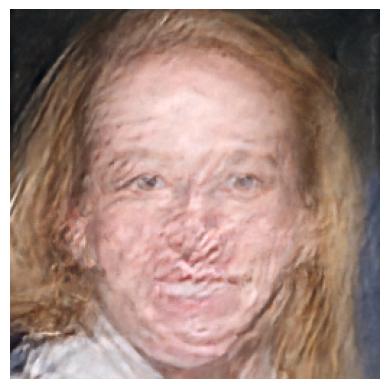

In [57]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_model_metface_0', bbox_inches='tight', pad_inches=0)

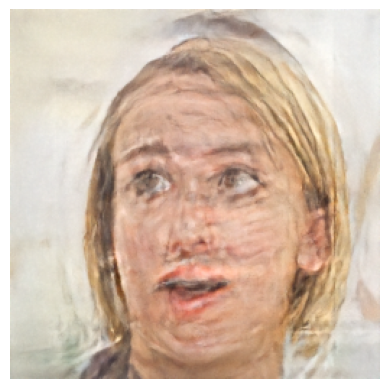

In [58]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][1].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_model_metface_1', bbox_inches='tight', pad_inches=0)

## Experiments with Alarmire dataset

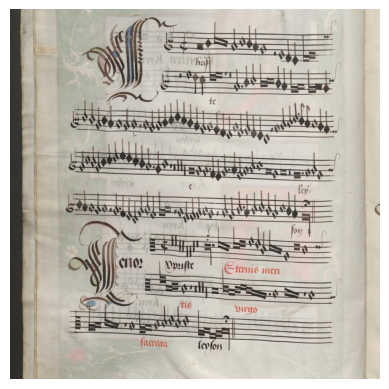

In [67]:
from PIL import Image

# Open the image file
img = Image.open('/content/drive/MyDrive/tien/images/A-Wn_15495_002v_4847_6798.jpeg')  # Replace with your image path

# Define the coordinates of the rectangle you want to crop
# The box is a 4-tuple defining the left, upper, right, and lower pixel coordinate.
left = 0
top = 226
right = 1024
bottom = 1250
crop_box = (left, top, right, bottom)

# Crop the image and show it
img = img.crop(crop_box)
# Resize the cropped image to 1024x1024
# resized_image = cropped_image.resize((1024, 1024))

# Display the resized image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [68]:
from PIL import Image
import os

# Define the directory to save the cropped images. Make sure it exists.
output_dir = '/content/gibbsddrm/exp/datasets/ood_ffhq/0'  # Update this to your desired directory
os.makedirs(output_dir, exist_ok=True)

# Image dimensions and desired crop size
original_width, original_height = img.size
crop_size = 256

# Coordinates for the 4 crops (top-left corners)
crop_coordinates = [(x * crop_size, y * crop_size) for y in range(4) for x in range(4)]


# Iterate over the coordinates and perform the crops
for i, (x, y) in enumerate(crop_coordinates):
    # Define the crop box
    crop_box = (x, y, x + crop_size, y + crop_size)

    # Perform the crop
    cropped_image = img.crop(crop_box)

    # Save the cropped image
    cropped_image_path = os.path.join(output_dir, f'cropped_image_{i+1}.jpg')
    cropped_image.save(cropped_image_path, 'JPEG')
    print(f'Saved: {cropped_image_path}')


Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_1.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_2.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_3.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_4.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_5.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_6.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_7.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_8.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_9.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_10.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_11.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_12.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_13.jpg
Saved: /content/gibbsddrm/exp/datasets/ood_ffhq/0/cropped_image_14.jpg
Saved: /content

In [76]:
## Get the dataset

dataset, test_dataset = get_dataset(args, config)

g = torch.Generator()
g.manual_seed(args.seed)
val_loader = data.DataLoader(
            test_dataset,
            batch_size=config.sampling.batch_size,
            shuffle=True,
            num_workers=config.data.num_workers,
            generator=g,
        )

pbar = tqdm.tqdm(val_loader)

for x_orig, classes in pbar:
    print(x_orig.shape)

 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


100%|██████████| 8/8 [00:01<00:00,  6.22it/s]


In [77]:
args.subset_start = 0
args.subset_end = len(test_dataset)
idx_init = args.subset_start
idx_so_far = args.subset_start

In [79]:
sigma_0 = 2 * config.deblur.sigma_0

x_orig = x_orig.to(device)
x_orig = data_transform(config, x_orig)
y_0 = H_funcs.H(x_orig)
y_0 = y_0 + sigma_0 * torch.randn_like(y_0)

WARNING - image.py - 2024-04-08 08:51:00,907 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


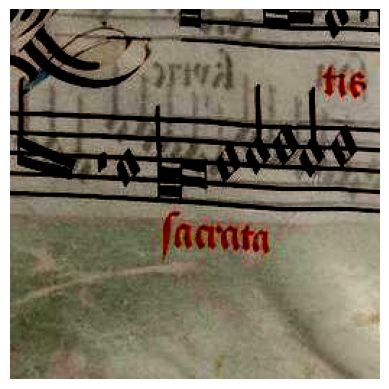

In [81]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x_orig[0]  # Example random tensor, replace with your own data

# Ensure the tensor is on CPU before converting to a numpy array
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

WARNING - image.py - 2024-04-08 08:51:39,677 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


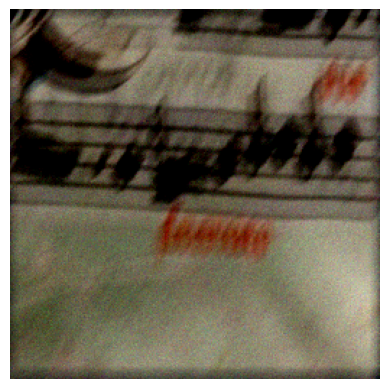

In [82]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = y_0[0]  # Example random tensor, replace with your own data

# Ensure the tensor is on CPU before converting to a numpy array
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

In [83]:
x = torch.randn(
                y_0.shape[0],
                config.data.channels,
                config.data.image_size,
                config.data.image_size,
                device=device,
            )

In [85]:
x = sample_image(x, model, H_funcs_uncert, y_0, sigma_0, last=True, classes=classes)

100it [06:21,  3.82s/it]


WARNING - image.py - 2024-04-08 09:01:10,148 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


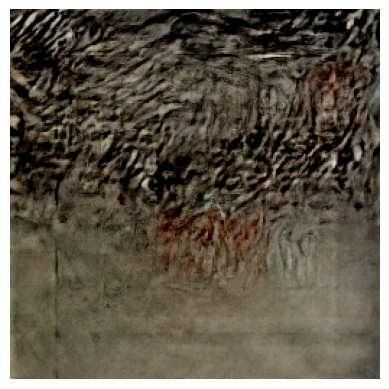

In [86]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x[0][0]  # Example random tensor, replace with your own data

# Convert the tensor to a numpy array and transpose dimensions
# For visualization, the tensor dimensions should be (height, width, channels)
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

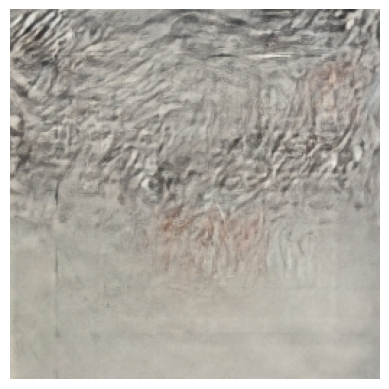

In [87]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_alarmire_0', bbox_inches='tight', pad_inches=0)

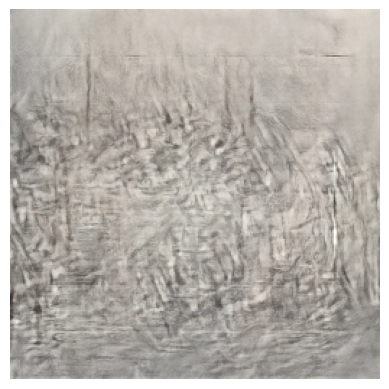

In [88]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][1].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_alarmire_1', bbox_inches='tight', pad_inches=0)

### try to deblur on the original alarmire dataset

In [89]:
x = torch.randn(
                y_0.shape[0],
                config.data.channels,
                config.data.image_size,
                config.data.image_size,
                device=device,
            )

In [90]:
x = sample_image(x, model, H_funcs_uncert, x_orig, sigma_0, last=True, classes=classes)

100it [06:23,  3.83s/it]


WARNING - image.py - 2024-04-08 09:14:13,974 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


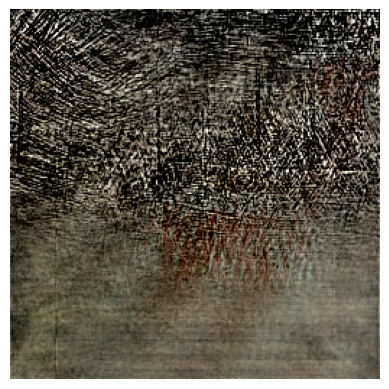

In [91]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your Torch tensor
tensor = x[0][0]  # Example random tensor, replace with your own data

# Convert the tensor to a numpy array and transpose dimensions
# For visualization, the tensor dimensions should be (height, width, channels)
image_array = tensor.permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()

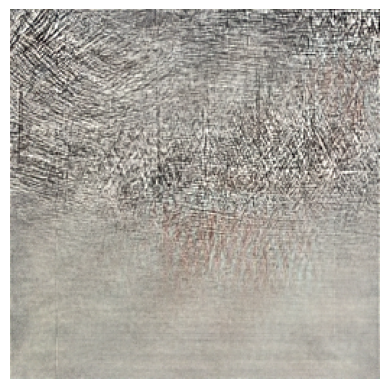

In [92]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_alarmire_org_0', bbox_inches='tight', pad_inches=0)

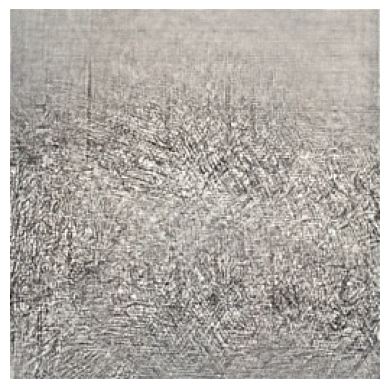

In [93]:
x_result = [inverse_data_transform(config, y) for y in x]
plt.imshow(x_result[0][1].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

plt.savefig('/content/drive/MyDrive/tien/images/exp_alarmire_org_1', bbox_inches='tight', pad_inches=0)